In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from collections import Counter

from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp import Poscar

from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import opposite_vertex_pairs
from polyhedral_analysis.octahedral_analysis import isomer_is_cis, isomer_is_mer, isomer_is_fac, isomer_is_trans

from bsym.interface.pymatgen import unique_structure_substitutions

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

from figure_formatting import figure_formatting as ff
ff.formatting['axes.linewidth'] = 0.5
ff.formatting['lines.linewidth'] = 1.0
ff.set_formatting()

colors = {'blue': '#264653',
          'bluegreen': '#287271',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [2]:
recipe = PolyhedraRecipe(method='distance cutoff', 
                         coordination_cutoff=3.0, 
                         central_atoms='Ti',
                         vertex_atoms=['O','F'])

In [3]:
class Config():
    
    def __init__(self,
                 structure: Structure,
                 config_id: int,
                 energy: float,
                 degeneracy: int) -> None:
        self.structure = structure
        self.config_id = config_id
        self.energy = energy
        self.degeneracy = degeneracy
        self.config = Configuration(structure=structure, recipes=[recipe])
        
    def n_non_f4o2(self) -> int:
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([v.label for v in p.vertices])
            if coord_count['F'] != 4:
                count += 1
        return count
    
    def n_collinear_oxygen(self) -> int:
        count = 0
        for p in self.config.polyhedra:
            vertex_pairs = opposite_vertex_pairs(p, check=False)
            for vp in vertex_pairs:
                if set([vp[0].label, vp[1].label]) == {'O'}:
                    count += 1
        return count
    
    def n_cis_f4o2(self) -> int:
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([v.label for v in p.vertices])
            if (coord_count['F'] == 4) and isomer_is_cis(polyhedron=p, check=False):
                count += 1
        return count
    
    def bond_lengths(self) -> list[float]:
        distances = {'O': [], 'F': []}
        for p in self.config.polyhedra:
            for d, l in p.vertex_distances_and_labels():
                distances[l].append( d )
        return distances
    
    def coordination_counts(self) -> dict[int]:
        f = [[p for p in self.config.polyhedra if p.vertex_count['F'] == n] for n in range(7)]
                     
        n_F2_trans = sum([isomer_is_trans(p, check=False) for p in f[2]])
        n_F3_mer = sum([isomer_is_mer(p, check=False) for p in f[3]])
        n_F4_trans = sum([isomer_is_trans(p, check=False) for p in f[4]])
        
        counts = {'O6': len(f[0]),
                  'O5F': len(f[1]),
                  'trans-O4F2': n_F2_trans,
                  'cis-O4F2': len(f[2]) - n_F2_trans,
                  'mer-O3F3': n_F3_mer,
                  'fac-O3F3': len(f[3]) - n_F3_mer,
                  'trans-O2F4': n_F4_trans,
                  'cis-O2F4': len(f[4]) - n_F4_trans,
                  'OF5': len(f[5]),
                  'F6': len(f[6])}
        
        return counts

In [4]:
data = pd.read_csv('../Data/energies.out',
                   delim_whitespace=True,
                   names=['config_id', 'ce_energy', 'dft_energy'],
                   na_values="None")
data.sort_values('config_id',
                 inplace=True)
data.ce_energy -= data.ce_energy.min()
data.dft_energy
data

,config_id,ce_energy,dft_energy
300,0,2.21448,-211.569551
2583,1,2.66760,-211.109399
2641,2,2.17216,-211.765435
1846,3,4.29128,-209.221864
254,4,3.02408,-210.189123
...,...,...,...
2616,2659,3.80192,NaN
1528,2660,0.43616,NaN
906,2661,0.66352,NaN
2547,2662,0.34864,NaN


In [5]:
poscar_dir = '../Data/poscars'

# dft_data_ids = data[data.dft_energy.notna()].config_id.values

configs = []
for i in tqdm(range(2664)):
    structure = Poscar.from_file(f'{poscar_dir}/config_{i:04d}.poscar').structure
    configs.append(Config(structure=structure,
                          config_id=i,
                          energy=data.iloc[i].ce_energy,
                          degeneracy=None))

100%|██████████████████████████████████████████████████████████████████████| 2664/2664 [00:07<00:00, 339.10it/s]


In [6]:
dft_data = data[data.dft_energy.notna()]
dft_data

,config_id,ce_energy,dft_energy
300,0,2.21448,-211.569551
2583,1,2.66760,-211.109399
2641,2,2.17216,-211.765435
1846,3,4.29128,-209.221864
254,4,3.02408,-210.189123
...,...,...,...
1322,2036,2.01368,-211.560276
402,2152,5.77936,-207.799661
2483,2564,0.06312,-213.464780
2248,2652,2.17504,-211.991662


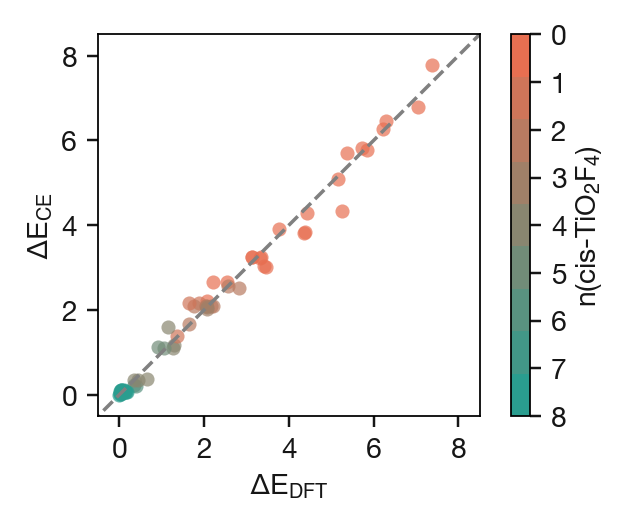

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define the two colors for interpolation
color2 = colors['dark orange'] 
color1 = colors['green']

# Create a user-defined colormap that interpolates between the two colors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=9)
cmap_inverted = cmap.reversed()  # Invert the colormap

fig, ax = plt.subplots()
for i in dft_data.config_id.values:
    d = dft_data[dft_data.config_id == i]
    plt.plot(d.dft_energy.values - dft_data.dft_energy.min(), d.ce_energy.values,
             'o', markerfacecolor=cmap_inverted(configs[i].n_cis_f4o2()),
             alpha=0.7, markersize=4, markeredgewidth=0)
ax.set_aspect('equal')
plt.xlim(-0.5, 8.5)
plt.ylim(-0.5, 8.5)
plt.xticks(np.arange(0,10,2))
plt.yticks(np.arange(0,10,2))
plt.plot([-1.0, 10.0], [-1.0, 10.0], '--', color='grey')
# Create a ScalarMappable object for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=8))
sm.set_array([])

cbar = fig.colorbar(sm, ticks=np.arange(0, 9), ax=plt.gca())
cbar.ax.set_yticklabels(np.arange(8, -1, -1))
cbar.set_label(r'n(cis-TiO$_2$F$_4$)')
plt.xlabel(r'$\Delta E_\mathrm{DFT}$')
plt.ylabel(r'$\Delta E_\mathrm{CE}$')
plt.savefig('../Figures/CE_fit.pdf', dpi=300)
plt.show()